### LIBRARIES

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
df1 = pd.read_csv("D:/University/2022-2023/HK2/thuThapVaTienXuLyDuLieu/fat_preprocessing/comments.csv", encoding="utf-8")

In [10]:
df1.head()

product_id  comment_id            title  thank_count  customer_id  rating  \
0    74021317    12559756  C·ª±c k√¨ h√†i l√≤ng          313     22051463       5   
1    74021317    16979365  C·ª±c k√¨ h√†i l√≤ng            6     27791831       5   
2    74021317    14069617  C·ª±c k√¨ h√†i l√≤ng           25     17748750       5   
3    74021317     8569824  C·ª±c k√¨ h√†i l√≤ng           57       410797       5   
4    74021317    18368714  C·ª±c k√¨ h√†i l√≤ng            0     28545286       5   

                                             comment  
0  C√≥ nh·ªØng ng∆∞·ªùi b∆∞·ªõc ƒë·∫øn, h·ªç l·∫•p ƒë·∫ßy h·∫°nh ph√∫c ...  
1  Th·∫•y nhi·ªÅu b·∫°n ch√™ tiki g√≥i h√†ng qu√°, may sao ...  
2  B√¨a c·ª±c xinh, tiki giao h√†ng nhanh, s√°ch kh√¥ng...  
3  S√°ch l√∫c nh·∫≠n h√¨nh th·ª©c r·∫•t ·ªïn, kh√¥ng cong v√™n...  
4  M·ªôt cu·ªën s√°ch r·∫•t ƒë√°ng ƒë·ªçc v·ªÅ t√¨nh y√™u th∆∞∆°ng ...

In [11]:
profile = ProfileReport(df1)
profile.get_description()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

{'analysis': {'title': 'Pandas Profiling Report',
  'date_start': datetime.datetime(2023, 4, 2, 11, 5, 51, 643465),
  'date_end': datetime.datetime(2023, 4, 2, 11, 6, 4, 674403),
  'duration': datetime.timedelta(seconds=13, microseconds=30938)},
 'table': {'n': 141281,
  'n_var': 7,
  'memory_size': 7911864,
  'record_size': 56.000905995852236,
  'n_cells_missing': 38022,
  'n_vars_with_missing': 2,
  'n_vars_all_missing': 0,
  'p_cells_missing': 0.038446176667168874,
  'types': {'Numeric': 4, 'Categorical': 3},
  'n_duplicates': 19411,
  'p_duplicates': 0.13739285537333398},
 'variables': {'product_id': {'n_distinct': 1974,
   'p_distinct': 0.013972154783728881,
   'is_unique': False,
   'n_unique': 0,
   'p_unique': 0.0,
   'type': 'Numeric',
   'hashable': True,
   'value_counts_without_nan': 53095307     300
   74021317     200
   8885995      200
   77105730     200
   117254517    200
               ... 
   207494295      2
   204957471      2
   206795253      2
   202961772    

In [12]:
df1['rating'].value_counts()

5    114514
4     14295
3      5276
1      4495
2      2701
Name: rating, dtype: int64

In [13]:
df1.shape

(141281, 7)

### Ph√¢n chia theo nh√≥m
Ta s·∫Ω chia b·ªô d·ªØ li·ªáu theo th√†nh t·ª´ng nh√≥m (class), trong ƒë√≥:
- 1-2: rating kh√¥ng th√≠ch
- 3: rating trung t√≠nh
- 4-5: rating th√≠ch

In [14]:
df_notlike = df1[df1['rating'] < 3 ]

In [15]:
df_neutral= df1[df1['rating'] == 3 ]

In [16]:
df_like = df1[df1['rating'] > 3 ]

### CHECK ISNULL

In [17]:
df2 = df1[["rating","comment"]].copy()

In [18]:
df2.isnull().sum()

rating         0
comment    38018
dtype: int64

In [19]:
df_isnull = df2[df2['comment'].isnull()]

In [20]:
df_isnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38018 entries, 770 to 141280
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   38018 non-null  int64 
 1   comment  0 non-null      object
dtypes: int64(1), object(1)
memory usage: 891.0+ KB


In [21]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5         35055
1       4          2906
2       3            45
3       1             9
4       2             3


### CHECK AND DROP DUPLICATED COMMENTS

In [22]:
df3 = df1[~df1['comment'].isnull()]

In [23]:
df3.duplicated().sum()

17264

In [24]:
df3.drop_duplicates(inplace=True)

In [25]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85999 entries, 0 to 141277
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   85999 non-null  int64 
 1   comment_id   85999 non-null  int64 
 2   title        85996 non-null  object
 3   thank_count  85999 non-null  int64 
 4   customer_id  85999 non-null  int64 
 5   rating       85999 non-null  int64 
 6   comment      85999 non-null  object
dtypes: int64(5), object(2)
memory usage: 5.2+ MB


In [26]:
for index, row in df3.sample(50).iterrows():
    print(row['comment'])

S√°ch kh√° ok
Ch·∫•t l∆∞·ª£ng gi·∫•y t·ªët tr·∫Øng- s√°ng, m·ª±c in r√µ r√†ng
N·ªôi dung m√¨nh ch∆∞a xem qua, n√™n kh√¥ng nx
Nh√¢n vi√™n b√™n ghn giao h√†ng r·∫•t l·ªãch s·ª±, m√¨nh ƒë√°nh gi√° cao kho·∫£ng n√†y
C√° nh√¢n m√¨nh c·∫£m th·∫•y kh√¥ng h√†i l√≤ng v·ªõi l·∫Øm v·ªõi c√°ch tiki ƒë√≥ng g√≥i s·∫£n ph·∫©m. Mong tiki s·∫Ω kh·∫Øc ph·ª•c
L·∫ßn sau, m√¨nh s·∫Ω ti·∫øp t·ª•c ·ªßng h·ªô tiki
Shop hi·∫øu c√°i mi·∫øng ƒë√°nh d·∫•u trang s√°ch c·ªßa em r·ªìi huhu
s√°ch in qu√° x·∫•u, h√¨nh minh h·ªça nh√≤e m√† x·∫•u
Ch·∫•t l∆∞·ª£ng t·ªët
Giao kh√° nhanh, m·ªõi ƒë·∫∑t tr∆∞a h√¥m tr∆∞·ªõc th√¨ s√°ng h√¥m sau ƒë√£ c√≥(d√π l√† ch·ªß nh·∫≠t), v·ªÅ h√¨nh th·ª©c th√¨ nh√¨n s∆° qua kh√¥ng b·ªã l·ªói hay g√¨. N·ªôi dung th√¨ c√≥ l·∫Ω ai c≈©ng bi·∫øt :v
Giao h√†ng nhanh, ƒë√≥ng g√≥i s∆° s√†i. Ch·ªâ nh√©t s√°ch v√†o h·ªôp th√¥i. May l√† s√°ch v·∫´n kh√¥ng sao, s√°ch m·ªõi, k c√≥ seal. Kh√¥ng qu√° khi n√≥i r·∫±ng m√¨nh nghƒ© ƒë√¢y l√† 1 t√°c ph·∫©m xu·∫•t s·∫Øc. Ngay t·ª´ ƒë·∫ßu, m√¨nh c·∫£m nh·∫≠n ƒë

In [27]:
df3.shape

(85999, 7)

### KEEP RATING AND COMMENT DATA

In [28]:
df4 = df3[['rating','comment']]

In [29]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['negative', 'neutral', 'positive']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [30]:
df4.reset_index(drop=True, inplace=True)

In [31]:
df4.head()

comment     class
0  C√≥ nh·ªØng ng∆∞·ªùi b∆∞·ªõc ƒë·∫øn, h·ªç l·∫•p ƒë·∫ßy h·∫°nh ph√∫c ...  positive
1  Th·∫•y nhi·ªÅu b·∫°n ch√™ tiki g√≥i h√†ng qu√°, may sao ...  positive
2  B√¨a c·ª±c xinh, tiki giao h√†ng nhanh, s√°ch kh√¥ng...  positive
3  S√°ch l√∫c nh·∫≠n h√¨nh th·ª©c r·∫•t ·ªïn, kh√¥ng cong v√™n...  positive
4  M·ªôt cu·ªën s√°ch r·∫•t ƒë√°ng ƒë·ªçc v·ªÅ t√¨nh y√™u th∆∞∆°ng ...  positive

In [32]:
df4.isnull().sum()

comment    0
class      0
dtype: int64

In [33]:
df4['class'].value_counts()

positive    76005
negative     5666
neutral      4328
Name: class, dtype: int64

### CLEAN TEXT

In [34]:
from processing import *

In [35]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

In [36]:
from processing import processing_text

Convert dask df to pd df

In [37]:
# Create a dask dataframe from the pandas dataframe
ddf = dd.from_pandas(df4, npartitions=16)
ddf = ddf.map_partitions(processing_text)
# Convert the dask dataframe to pandas dataframe
with ProgressBar():
    df = ddf.compute(num_workers=7)
del ddf

[########################################] | 100% Completed | 366.53 s


In [38]:
for index, row in df.sample(100).iterrows():
    print(row['processed_text'])

s√°ch c√¢u_chuy·ªán quan_ƒëi·ªÉm r·∫•t_m·ªõi t·ªëi_gi·∫£n to√†n_di·ªán c√¢u nh·∫π_nh√†ng
n·ªôi s√°ch ti√™ng s√°ch m√†u n√¢u_ƒëen t√°i_b·∫£n kh√¥ng_r√µ c·∫≠p_nh·∫≠t nh∆∞_b·∫£n b√¨a v√†ng ch·ªânh_l√Ω kh√¥ng h∆°i_th·∫•t v·ªçng s·ª£ c≈© ch·ªó l·ªói_th·ªùi c·ªë t√°i_b·∫£n b√¨a v√†ng
s√°ch thi·∫øt_k·∫ø ƒë·∫πp gi·∫•y n·ªôi h√†ng h√†i_l√≤ng

b·ªçc s√°ch h∆∞ s√°ch ch√°n ch·∫£ ƒë·ªçc
s√°ch t·ªânh s√°ch b·ªçc m√†ng s√°ch b·ªã_nh√†u n√°t c·ª±c_k·ª≥ h√†i_l√≤ng ch·∫•t_l∆∞·ª£ng s√°ch n·ªôi h√¨nh_th·ª©c gi√∫p_√≠ch th·ªùi c·ª≠a_h√†ng ƒë·ªãa_ph∆∞∆°ng h√∫t kh√°ch_h√†ng nh∆∞_n√†o

h√†ng s√°ch ƒë·∫πp
s√°ch xinhhhh xƒ©u b·ªçc h√†ng r·∫•t_c·∫©n th·∫≠n s√°ch kh√¥ng_b·ªã h√†ng t·∫∑ng s√°ch m√πi s√°ch th∆°m l·∫Øm
h√†ng c·ª±c ƒë√≥ng_g√≥i c·∫©n_th·∫≠n s√°ch
ƒë·ªçc quy·ªÉn h·ªçc ƒë·ªçc ƒë·ªïi quan_ƒëi·ªÉm r·∫°ch_r√≤i nh∆∞_sergio ph√¢n_t√≠ch b·ªïng th·∫ßn_th√°nh_h√≥a k√¨_di·ªáu ƒëo_l∆∞·ªùng v·ªçng l√†m_vi·ªác hi·ªáu_qu·∫£ th·ªùi sergio
s√°ch ƒë·∫πp d√†y c√≥_l·∫Ω n·ªôi l·∫Øm v√¥_d·ª•ng h∆°i_s∆° s√†i g√≥c m·∫∑t t√≥c 

In [39]:
df.reset_index(drop=True, inplace=True)

In [40]:
df_final = df[['processed_text','class']]

In [41]:
df_final.head()

processed_text     class
0  l·∫•p h·∫°nh_ph√∫c v·∫øt n·ª©t ·ªßi ch·ªØa v·ª° tr√°i c√¢u_chuy...  positive
1  ch√™ g√≥i h√†ng qu√°_h√†ng kh√¥ng_b·ªã h∆∞ t·∫πo h∆°i_s∆° s...  positive
2  b√¨a c·ª±c h√†ng s√°ch kh√¥ng_b·ªã nhƒÉn g√≥c g√£y c·∫°nh b...  positive
3  s√°ch h√¨nh_th·ª©c r·∫•t_·ªïn kh√¥ng_v√™nh x∆∞·ªõc g√£y ƒë∆°n ...  positive
4  s√°ch r·∫•t_ƒë√°ng ƒë·ªçc t√¨nh_y√™u_th∆∞∆°ng m·∫•t_m√°t g·ª£i_...  positive

In [42]:
df_final['processed_text'].loc[1]

'ch√™ g√≥i h√†ng qu√°_h√†ng kh√¥ng_b·ªã h∆∞ t·∫πo h∆°i_s∆° s√†i kh√¥ng_b·ªçc ch·ªëng x√≥c s√°ch rewiew s√°ch jhas vi·∫øt ki·ªÉu ƒë·ªçc kh√¥ng_ch√°n s∆∞ kh√°m_ph√° n·ªói ƒëau'

In [43]:
df_final.to_csv('comment_final.csv')

### VISUALIZE USING WORDCLOUD

Negative

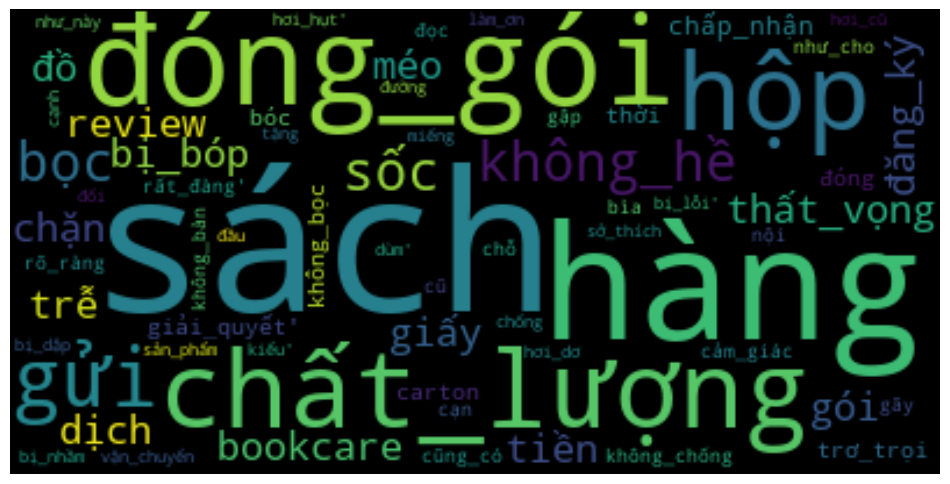

In [44]:
df_final_notlike = df_final[df_final['class'] == 'negative' ]
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
wc_notlike.generate(str(df_final_notlike['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

Neutral

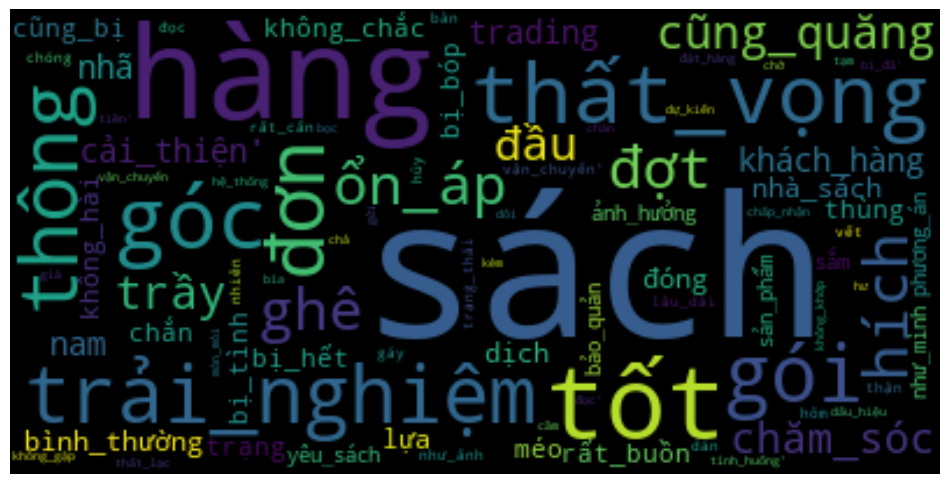

In [45]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
wc_neutral.generate(str(df_final_neutral['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive

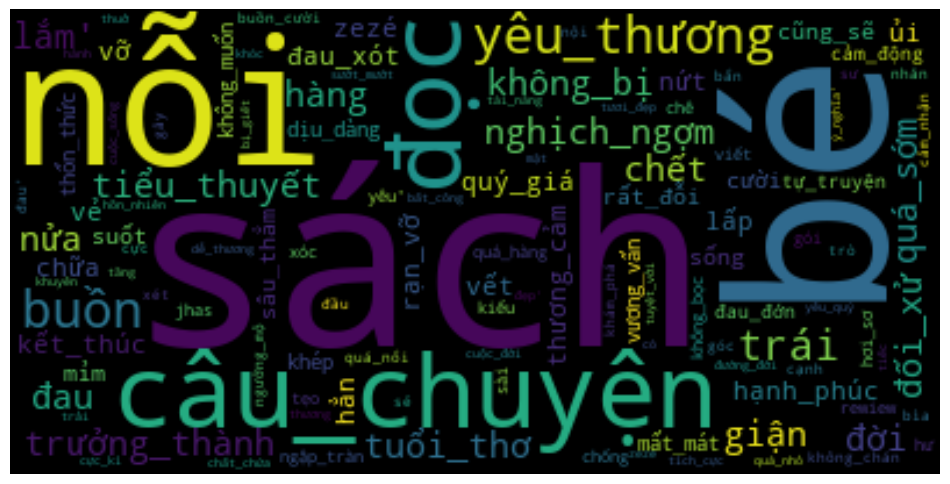

In [46]:
df_final_like = df_final[df_final['class'] == 'positive' ]
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
wc_like.generate(str(df_final_like['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()